# 1. data

$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification

In [5]:
print('run')

run


In [6]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. data_loader

실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [7]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words = 10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how='any')
    test_data.drop_duplicates(subset=['document'], inplace = True)
    test_data = test_data.dropna(how='any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)


In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. 모델 구성을 위한 데이터 분석 및 가공 

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

리뷰의 최대 길이 : 116
리뷰의 평균 길이 : 15.981687211831826


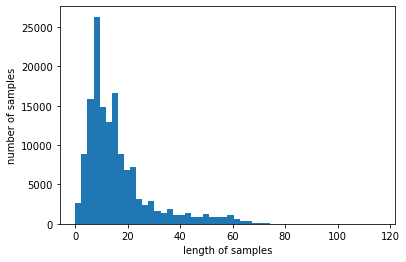

In [10]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [11]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [12]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 93.0490758096072


In [13]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4. 모델 구성 및 validation set 구성


모델은 3가지 이상 다양하게 구성하여 실험해 보세요.


# LSTM model

In [14]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [15]:
vocab_size = 10000
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 5. 모델 훈련 개시

In [17]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2) 
# validation set은  fit 할 때 할당해주었다.

Epoch 1/15
1947/1950 [============================>.] - ETA: 0s - loss: 0.3832 - acc: 0.8289
Epoch 00001: val_acc improved from -inf to 0.84147, saving model to best_model.h5
1950/1950 [==============================] - 16s 8ms/step - loss: 0.3831 - acc: 0.8289 - val_loss: 0.3720 - val_acc: 0.8415
Epoch 2/15
1948/1950 [============================>.] - ETA: 0s - loss: 0.3161 - acc: 0.8642
Epoch 00002: val_acc improved from 0.84147 to 0.85645, saving model to best_model.h5
1950/1950 [==============================] - 16s 8ms/step - loss: 0.3160 - acc: 0.8642 - val_loss: 0.3433 - val_acc: 0.8564
Epoch 3/15
1944/1950 [============================>.] - ETA: 0s - loss: 0.2906 - acc: 0.8777
Epoch 00003: val_acc improved from 0.85645 to 0.85901, saving model to best_model.h5
1950/1950 [==============================] - 16s 8ms/step - loss: 0.2907 - acc: 0.8777 - val_loss: 0.3222 - val_acc: 0.8590
Epoch 4/15
1946/1950 [============================>.] - ETA: 0s - loss: 0.2745 - acc: 0.8868
Epoc

In [18]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 3ms/step - loss: 0.3054 - acc: 0.8711

 테스트 정확도: 0.8711


# 6. loss, accuracy 그래프 시각화

In [19]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


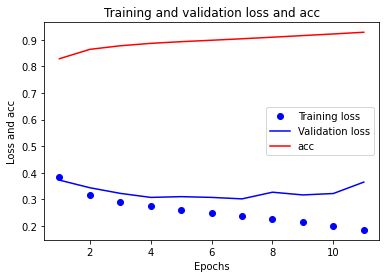

In [20]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, acc, 'r',label='acc')
plt.title('Training and validation loss and acc')
plt.xlabel('Epochs')
plt.ylabel('Loss and acc')
plt.legend()

plt.show()

# 7. 학습된 embeding layer 분석

In [21]:
# 자체학습한 임베딩 분석? 이걸 어떻게 해야할 지...

In [22]:
from gensim.models.word2vec import Word2Vec

word2vec_model = Word2Vec.load('/home/aiffel/aiffel/naver_review/ko/ko.bin')

print('사랑: ',word2vec_model.most_similar(positive=["사랑"]))
print('영웅: ',word2vec_model.most_similar(positive=["영웅"]))
print('파국: ',word2vec_model.most_similar(positive=["파국"]))

# 이미 학습한 레이어를 가지고 와서 사랑,영웅,파국을 분석하였다. 비슷 비슷한 단어를 가져온 걸로보아 성능은 괜찮은 것으로 보인다.

사랑:  [('슬픔', 0.7216663360595703), ('행복', 0.6759077310562134), ('절망', 0.6468985676765442), ('기쁨', 0.6458414793014526), ('이별', 0.6334798336029053), ('추억', 0.6320937871932983), ('인생', 0.6216273307800293), ('애정', 0.6206068992614746), ('연인', 0.6186063289642334), ('유혹', 0.5965287685394287)]
영웅:  [('악당', 0.5823014974594116), ('여신', 0.5505523681640625), ('거인', 0.5494499206542969), ('비극', 0.5426483154296875), ('용사', 0.5414282083511353), ('요정', 0.5367072224617004), ('서사시', 0.5364639163017273), ('주인공', 0.5148755311965942), ('악마', 0.5130380392074585), ('마법사', 0.5130000114440918)]
파국:  [('과도기', 0.5172320008277893), ('격변', 0.5143023729324341), ('인륜', 0.4792666435241699), ('파멸', 0.4749737083911896), ('전체주의', 0.46998634934425354), ('권위주의', 0.45743483304977417), ('격동', 0.4573524296283722), ('변혁', 0.4527782201766968), ('파탄', 0.4488372802734375), ('비민주', 0.44860202074050903)]


/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  import sys


# 8. 한국어 word2vec 임베딩 활용하여 성능개선

In [23]:
print(word2vec_model)

Word2Vec(vocab=30185, size=200, alpha=0.025)


In [24]:
t = Tokenizer()

vocab_size = 30185    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None
 
for word, i in t.word_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.




from tensorflow.keras.initializers import Constant





# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(20, 7, activation='relu'))
model.add(keras.layers.Conv1D(20, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 5, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 


In [25]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/20
229/229 [==============================] - 28s 120ms/step - loss: 0.6891 - accuracy: 0.5299 - val_loss: 0.6448 - val_accuracy: 0.6583
Epoch 2/20
229/229 [==============================] - 16s 72ms/step - loss: 0.5104 - accuracy: 0.7430 - val_loss: 0.4559 - val_accuracy: 0.7800
Epoch 3/20
229/229 [==============================] - 17s 73ms/step - loss: 0.4232 - accuracy: 0.7991 - val_loss: 0.4381 - val_accuracy: 0.7899
Epoch 4/20
229/229 [==============================] - 17s 73ms/step - loss: 0.3935 - accuracy: 0.8148 - val_loss: 0.4360 - val_accuracy: 0.7936
Epoch 5/20
229/229 [==============================] - 17s 73ms/step - loss: 0.3726 - accuracy: 0.8256 - val_loss: 0.4692 - val_accuracy: 0.7771
Epoch 6/20
229/229 [==============================] - 17s 74ms/step - loss: 0.3494 - accuracy: 0.8395 - val_loss: 0.4658 - val_accuracy: 0.7821
Epoch 7/20
229/229 [==============================] - 17s 73ms/step - loss: 0.3255 - accuracy: 0.8531 - val_loss: 0.4688 - val_accuracy

75퍼밖에 나오지 않는다.

# 회고
너무 어려워서 이해하는 데에 오래걸렸고, 팀원분들과 같이 하면서 차근차근 배워나가니 이해가 되었다. 여전히 모르는 게 많지만 조금씩 하다보면 잘 될거라 믿는다.